# Multivariate to each input/output Time Series

In [108]:
import numpy as np
import time
import math
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error

import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters
# https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/
# https://www.gritfeat.com/explainable-aixai-from-correlation-to-causation-shap-for-lstm-time-series-model/
#http://localhost:8888/lab/tree/MyQuantFinProject/TimeSeriesML-FinMarket/Nachiketa-Hebbar-LSTM/RNN_Youtube.ipynb

In [109]:
ab_path = "../data/SET50-Daily-Y09-Now.csv"
stockname='SET50'
start_date='2016-01-01'
end_date='2022-12-31'



# EMA2 and Signal
prediction_col='Price'
my_features=['Price', 'EMA1','EMA2','EMA3','MACD', 'SIGNAL', 'RSI','RSI-MA']
#my_features=['Price', 'EMA1','EMA2','MACD', 'SIGNAL', 'RSI','RSI-MA']
# each feature predict itself

n_early=6

train_ratio=0.8


n_batch=32
n_epochs=100

my_model_loss='mean_absolute_error'
my_model_metrics=[my_model_loss]
my_obj_tune="mae"

# 10 predict 1 
# 60 predict 1
n_input =60
# define generator

n_features = len(my_features)
print(f"input={n_input} and features={n_features}")

tune_folder='multivar_tune'


seed=7


input=60 and features=8


# Load Data

In [110]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':'Date'},inplace=True)
allCols=list(df.columns)
print(allCols)

df['Date']=df['Date'].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index('Date',inplace=True)
df=df.loc[start_date:end_date][my_features]
print(df.info())
print(df.tail(3))



['Ticker', 'Date', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1702 entries, 2016-01-04 to 2022-12-30
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1702 non-null   float64
 1   EMA1    1702 non-null   float64
 2   EMA2    1702 non-null   float64
 3   EMA3    1702 non-null   float64
 4   MACD    1702 non-null   float64
 5   SIGNAL  1702 non-null   float64
 6   RSI     1702 non-null   float64
 7   RSI-MA  1702 non-null   float64
dtypes: float64(8)
memory usage: 119.7 KB
None
              Price    EMA1    EMA2    EMA3  MACD  SIGNAL    RSI  RSI-MA
Date                                                                    
2022-12-28  1000.54  985.80  983.87  983.87  1.92   -0.09  65.03   54.98
2022-12-29  1010.19  990.23  986.38  986.38  3.85    0.41  69.99   59.54
2022-12-30  1005.24  992.96  988.17  988.17  4.79    0.95  64.93   63.01


# Tranform Data

In [111]:
print("Tranform Data")
dfValues=df.values
print(dfValues.shape)
train_data_len = math.ceil(len(dfValues) * train_ratio)
print(f"{train_ratio} of {len(dfValues)} = The number of train data is {train_data_len}")
train_values = dfValues[0:train_data_len]
test_values = dfValues[train_data_len:]
print(train_values.shape,test_values.shape)
    
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
scaler = MinMaxScaler()
#scaler= PowerTransformer()
scaler.fit(train_values)
train = scaler.transform(train_values)
test = scaler.transform(test_values)

print(train.shape,test.shape)
print(type(train),type(test))
print(train[-2:])
print(test[-2:])

Tranform Data
(1702, 8)
0.8 of 1702 = The number of train data is 1362
(1362, 8) (340, 8)
(1362, 8) (340, 8)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[0.46663119 0.4176142  0.38593197 0.38593197 0.62184124 0.59529992
  0.35929131 0.26231672]
 [0.43983734 0.41301347 0.38167112 0.38167112 0.618571   0.59478058
  0.26768301 0.26480938]]
[[0.62731833 0.56479352 0.52146073 0.52146073 0.72966009 0.69163854
  0.71817058 0.57815249]
 [0.61791198 0.57077446 0.52576972 0.52576972 0.73897532 0.6986497
  0.64867463 0.62903226]]


# Generate Timeseries For LSTM

In [112]:
# each feature predict itself
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)
n_output=len(my_features)

# each feature predict one output , 0=close is targer 
# generator = TimeseriesGenerator(train,train[:,0], length=n_input, batch_size=1)
# n_output=1

# number of samples
print(f'Samples: {len(generator)}')
# print each sample
for i in range(len(generator)):
 x, y = generator[i]
 if i<=1:
    # n_output=y.shape[1]
    # print("Output: ",n_output)
    print(x.shape,y.shape)  
    print(f'{x} => {y}')
    print("=========================")
    


Samples: 1302
(1, 60, 8) (1, 8)
[[[0.21830344 0.17640486 0.13540839 0.13540839 0.56198593 0.50727084
   0.15973081 0.20249267]
  [0.20076391 0.1655603  0.12616451 0.12616451 0.55098603 0.50662166
   0.12621893 0.17800587]
  [0.20893509 0.15839632 0.1187983  0.1187983  0.54890496 0.5057128
   0.16632331 0.16143695]
  [0.15521435 0.1412641  0.10565465 0.10565465 0.52561689 0.50116853
   0.07636314 0.12947214]
  [0.18586576 0.13368386 0.0974459  0.0974459  0.5251214  0.49701376
   0.20120863 0.12052786]
  [0.17053056 0.12426334 0.08817794 0.08817794 0.52066198 0.49272916
   0.17470128 0.12360704]
  [0.20154302 0.12305839 0.08353193 0.08353193 0.53433753 0.49117112
   0.28416426 0.15733138]
  [0.23531088 0.12917077 0.08341157 0.08341157 0.56248142 0.49441703
   0.38387584 0.20381232]
  [0.20872606 0.12857925 0.08008955 0.08008955 0.57348132 0.49909115
   0.32715286 0.25733138]
  [0.17746656 0.12154672 0.07330108 0.07330108 0.56951739 0.50246689
   0.26878176 0.27184751]
  [0.17414108 0.115

# LSTM Train

In [113]:
#neuron_number=100

np.random.seed(7)



In [114]:
#1 feature  to predict  1 output
print("Get n_input to set step for neuron")
neuron_number=n_input
step_neuron=int(neuron_number/1)
max_neuron=step_neuron*4
print(f"{neuron_number}= {n_input} (univariate n_features=1) with step {step_neuron} until {max_neuron}")

min_drop=0.0
max_drop=0.3
step_drop=0.1

ratio_traial_max=0.7  # 0.6/0.7

neuron_list = [*range(neuron_number, max_neuron+step_neuron, step_neuron)]

drop_list=np.arange (min_drop, max_drop ,step_drop)
drop_list=np.append(drop_list,[max_drop])

allPosComb=len(neuron_list)*len(drop_list)
print(f"{neuron_list} and {drop_list}")
print(f"all combination : {len(neuron_list)} x {len(drop_list)} = {allPosComb}")

nMax_trials=int(allPosComb*ratio_traial_max)
nExecutions_per_trial=3

print(f"Max Run={nMax_trials} of {allPosComb} e and each will repeat for essembling model= {nExecutions_per_trial}")



Get n_input to set step for neuron
60= 60 (univariate n_features=1) with step 60 until 240
[60, 120, 180, 240] and [0.  0.1 0.2 0.3]
all combination : 4 x 4 = 16
Max Run=11 of 16 e and each will repeat for essembling model= 3


In [115]:
# def my_model(neuron_number,dropout_rate,isTuning):   
def my_model(neuron_number,dropout_rate):  
 model = Sequential()

 model.add(LSTM(units=neuron_number, activation='relu',return_sequences=False, input_shape=(n_input, n_features))) 
 
# if (isTuning==True) or (isTuning==False and dropout_rate>0):
 #  model.add(Dropout(dropout_rate))  
 # else:
 #  print(f"Ignore drop rate {dropout_rate}")  
 model.add(Dropout(dropout_rate))    

 model.add(Dense(n_output))

#https://keras.io/api/metrics/
#https://keras.io/api/losses/
 model.compile(loss=my_model_loss, optimizer='adam',metrics = my_model_metrics)

 return model


# Tunine Step

In [116]:
def build_hp_model(hp):
    x_neuron_number=hp.Int('input_unit',min_value=neuron_number ,max_value=max_neuron,step=step_neuron)
    x_dropout_rate=hp.Float('Dropout_rate',min_value=min_drop,max_value=max_drop,step=step_drop)
    
    # model=my_model( x_neuron_number, x_dropout_rate,True)
    model=my_model( x_neuron_number, x_dropout_rate)

    return model
# create emply HyperParameters data
build_hp_model(kt.HyperParameters())


In [117]:
print(f"Loss={my_model_loss} , MeasureList={my_model_metrics} , Objective Metrict to Tune = {my_obj_tune}")

Loss=mean_absolute_error , MeasureList=['mean_absolute_error'] , Objective Metrict to Tune = mae


In [118]:
t_Start=time.time()

print(f"Start tund at {datetime.now()}")

buildtime = datetime.now().strftime('%d%m%y_%H%M')
project_model=f"multi_inout_bayesian{buildtime}"
print(project_model)

Start tund at 2023-01-11 15:47:17.407658
multi_inout_bayesian110123_1547


In [ ]:

tuner = kt.BayesianOptimization(
# tuner = kt.Hyperband(
# tuner= kt.RandomSearch(
        build_hp_model,
        objective=my_obj_tune,
        max_trials=nMax_trials,
        seed=seed,
        executions_per_trial=nExecutions_per_trial,
        directory=f"{tune_folder}/",
        project_name= project_model   
        )

if (n_early>0):
 early_stop = EarlyStopping(monitor='loss', patience=n_early, verbose=1)
 tuner.search(generator, batch_size=n_batch, epochs=n_epochs,
                        shuffle=False,verbose=1,callbacks=[early_stop])
else:
 tuner.search(generator, batch_size=n_batch, epochs=n_epochs,
                        shuffle=False,verbose=1)   



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
120               |?                 |input_unit
0.1               |?                 |Dropout_rate

Epoch 1/100
1302/1302 [==============================] - 19s 13ms/step - loss: 0.0796 - mean_absolute_error: 0.0796
Epoch 2/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0597 - mean_absolute_error: 0.0597
Epoch 3/100
1302/1302 [==============================] - 18s 14ms/step - loss: 0.0553 - mean_absolute_error: 0.0553
Epoch 4/100
1302/1302 [==============================] - 18s 14ms/step - loss: 0.0496 - mean_absolute_error: 0.0496
Epoch 5/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0485 - mean_absolute_error: 0.0485
Epoch 6/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0429 - mean_absolute_error: 0.0429
Epoch 7/100
1302/1302 [==============================] - 18s 14ms/step - loss: 0.0386 - mean_absolute_error: 0.0386
Epoch 8

In [ ]:
print("Space to search")
tuner.search_space_summary()
print(f"Suumary of {nMax_trials}")
tuner.results_summary()

In [ ]:
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execution : ',round(t_elapsed,2)) 
print(datetime.now())

In [ ]:
print("Query the results")
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print("Show best hyperparamter values")
print(best_hps.values)
best_model=tuner.get_best_models(num_models=1)[0]
best_model.summary()


In [ ]:
print("# Build the model with the optimal hyperparameters and train it on the data for X epochs")
model = tuner.hypermodel.build(best_hps)  # for retrain to get history and predict while develop
model.summary()

# run muanyula
#model=my_model(neuron_number,0,False)

In [ ]:
print("Completed Tune")

# Fit Model frpom best model

In [124]:
if (n_early>0):
 history=model.fit(generator,epochs=n_epochs,batch_size=n_batch,shuffle=False,callbacks=[early_stop],verbose=1)
else:
 history=model.fit(generator,epochs=n_epochs,batch_size=n_batch,shuffle=False,verbose=1)   

Epoch 1/100
1302/1302 [==============================] - 19s 13ms/step - loss: 0.0082 - mse: 0.0082
Epoch 2/100
1302/1302 [==============================] - 18s 14ms/step - loss: 0.0053 - mse: 0.0053
Epoch 3/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0043 - mse: 0.0043
Epoch 4/100
1302/1302 [==============================] - 18s 13ms/step - loss: 0.0033 - mse: 0.0033
Epoch 5/100
1302/1302 [==============================] - 23s 18ms/step - loss: 0.0023 - mse: 0.0023
Epoch 6/100
1302/1302 [==============================] - 30s 23ms/step - loss: 0.0018 - mse: 0.0018
Epoch 7/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0015 - mse: 0.0015
Epoch 8/100
1302/1302 [==============================] - 18s 13ms/step - loss: 0.0014 - mse: 0.0014
Epoch 9/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0014 - mse: 0.0014
Epoch 10/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0013 - mse: 0.0013

In [125]:
val_per_epoch = history.history['mse']
#best_epoch = val_per_epoch.index(max(val_per_epoch)) + 1
best_epoch = len(val_per_epoch) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 101


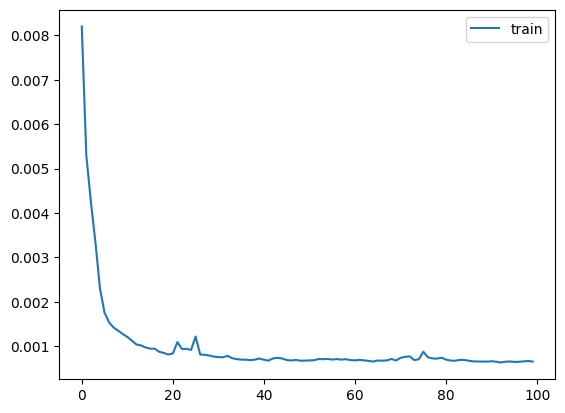

In [126]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

# Get Test Data(Unseen) by include {n_input_lookback} to predict

# Set Test data for prediction

In [127]:
# test_arr will get start with the last n look back to predict
idx_train_to_test=len(dfValues)-len(test_values)-n_input
print("The first train data to predict the frist test :",idx_train_to_test)



The first train data to predict the frist test : 1302


In [128]:
test_arr=dfValues[idx_train_to_test:]
print(f"Get Test Data {len(test_values)} + {n_input} to predict = {test_arr.shape}")
print(test_arr.shape)
test_scaled_arr=scaler.fit_transform(test_arr)
print(test_scaled_arr.shape)
print(test_scaled_arr[:2])


Get Test Data 340 + 60 to predict = (400, 8)
(400, 8)
(400, 8)
[[0.39979598 0.31721968 0.31755808 0.31755808 0.35351003 0.33826638
  0.54722062 0.4088748 ]
 [0.38033584 0.32589626 0.32123177 0.32123177 0.3739255  0.3435518
  0.52567802 0.41408196]]


In [129]:
#No.row = len(test_arr)-n_hop_lookback  , we will start triaing at the first rows since n_hop
X_test=[]
for i in range(n_input,test_scaled_arr.shape[0]):
   X_test.append(test_scaled_arr[i-n_input:i]) 
X_test=np.array(X_test)
print(X_test.shape)
print(X_test[:2])

(340, 60, 8)
[[[0.39979598 0.31721968 0.31755808 0.31755808 0.35351003 0.33826638
   0.54722062 0.4088748 ]
  [0.38033584 0.32589626 0.32123177 0.32123177 0.3739255  0.3435518
   0.52567802 0.41408196]
  [0.34565286 0.32532418 0.32004322 0.32004322 0.37571633 0.34830867
   0.48720908 0.46139914]
  [0.23407094 0.3002479  0.30437601 0.30437601 0.33345272 0.34460888
   0.37468744 0.44690967]
  [0.23681733 0.28032037 0.29054565 0.29054565 0.30444126 0.33615222
   0.37814964 0.41385556]
  [0.23924984 0.26449275 0.27833603 0.27833603 0.28545845 0.3255814
   0.38122716 0.3746887 ]
  [0.31677652 0.26878337 0.27747164 0.27747164 0.30444126 0.3192389
   0.48028467 0.364048  ]
  [0.27440364 0.26287185 0.2710967  0.2710967  0.30336676 0.31395349
   0.43239084 0.35114331]
  [0.233914   0.24904653 0.26007563 0.26007563 0.28796562 0.30655391
   0.38815157 0.35431288]
  [0.22779347 0.23646072 0.24927066 0.24927066 0.2765043  0.29756871
   0.3814195  0.35521847]
  [0.20660703 0.22139588 0.2367369  0.23

# Prediction

In [130]:
y_test_scaled_pred=model.predict(X_test)
print("Before Invert :",y_test_scaled_pred.shape)
y_test_scaled_pred[:3]

11/11 [==============================] - 0s 12ms/step
Before Invert : (340, 8)


array([[0.2151913 , 0.10917796, 0.07638372, 0.07642112, 0.4807732 ,
        0.24200475, 0.26944745, 0.25013387],
       [0.20730002, 0.09383596, 0.05904332, 0.05903748, 0.4839278 ,
        0.22896054, 0.26148453, 0.24195972],
       [0.22947088, 0.10119992, 0.05823421, 0.05807975, 0.5260141 ,
        0.24261874, 0.31414545, 0.29444784]], dtype=float32)

In [131]:
y_test_pred=scaler.inverse_transform(y_test_scaled_pred)
print("After Invert :" ,y_test_pred.shape)
y_test_pred[:3]

After Invert : (340, 8)


array([[935.92395  , 930.14056  , 931.0293   , 931.0327   ,   2.163188 ,
         -3.4312701,  37.968575 ,  40.77841  ],
       [934.91833  , 928.5315   , 929.42444  , 929.4239   ,   2.2512639,
         -3.6780665,  37.55458  ,  40.41736  ],
       [937.7438   , 929.3039   , 929.34955  , 929.33527  ,   3.4263134,
         -3.4196534,  40.292423 ,  42.73576  ]], dtype=float32)

# Create Predction DataFrame and Measure and Plot Chart

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        340 non-null    float64
 1   Price-Pred   340 non-null    float32
 2   EMA1         340 non-null    float64
 3   EMA1-Pred    340 non-null    float32
 4   EMA2         340 non-null    float64
 5   EMA2-Pred    340 non-null    float32
 6   EMA3         340 non-null    float64
 7   EMA3-Pred    340 non-null    float32
 8   MACD         340 non-null    float64
 9   MACD-Pred    340 non-null    float32
 10  SIGNAL       340 non-null    float64
 11  SIGNAL-Pred  340 non-null    float32
 12  RSI          340 non-null    float64
 13  RSI-Pred     340 non-null    float32
 14  RSI-MA       340 non-null    float64
 15  RSI-MA-Pred  340 non-null    float32
dtypes: float32(8), float64(8)
memory usage: 32.0 KB
None


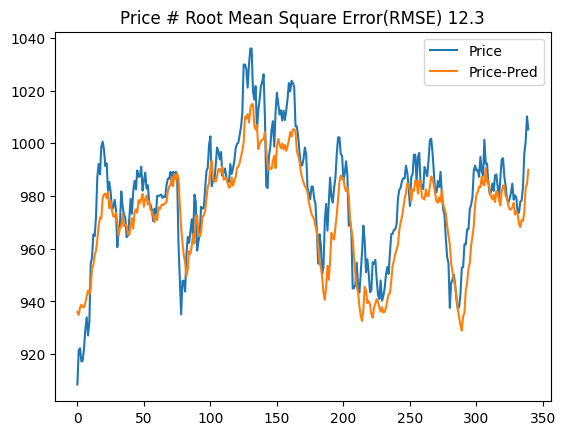

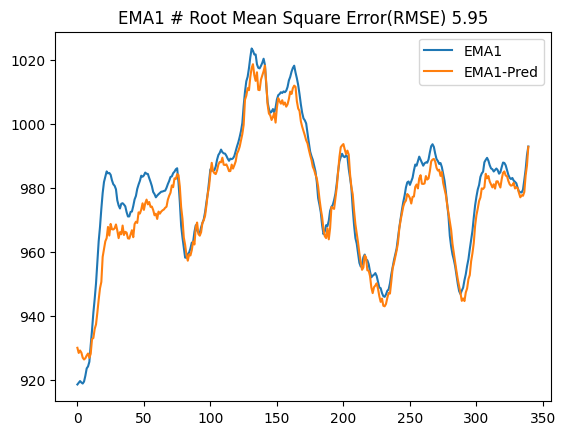

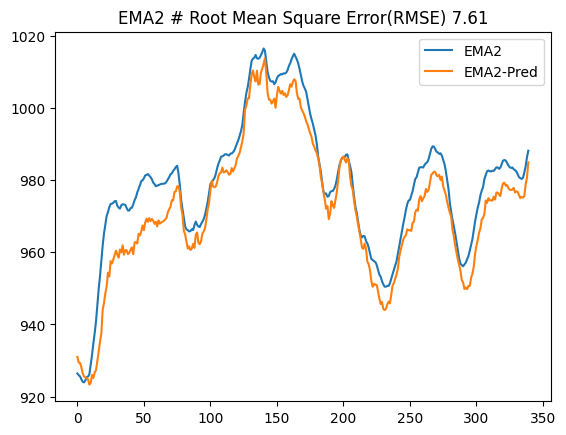

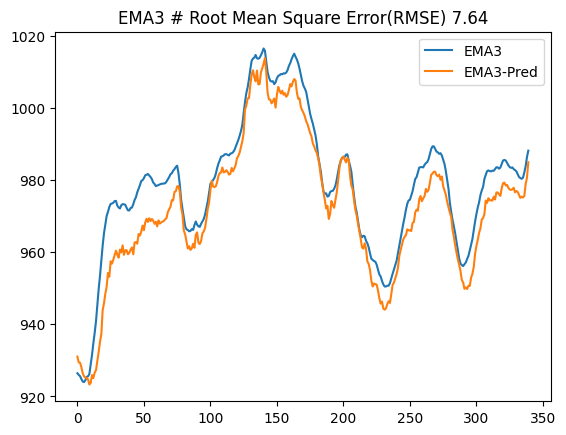

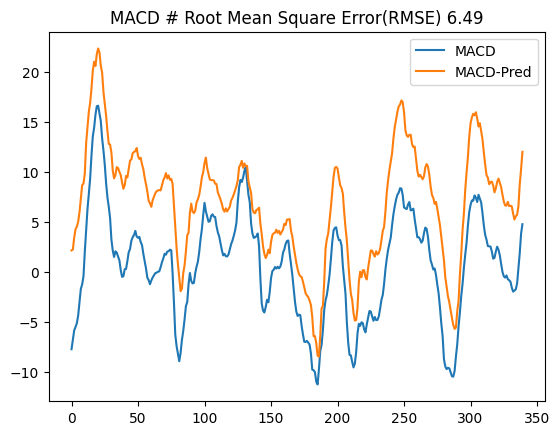

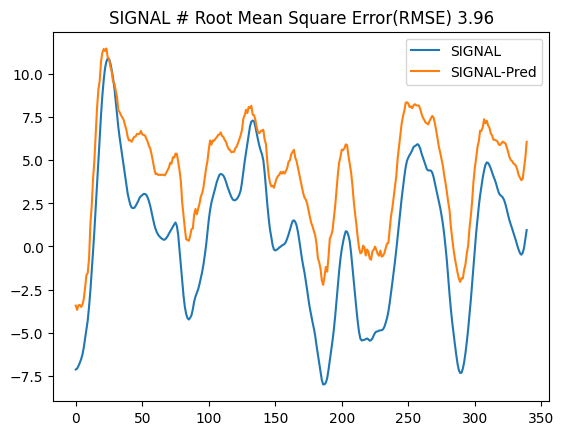

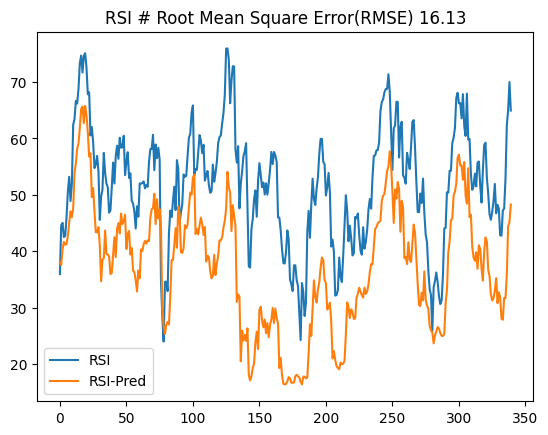

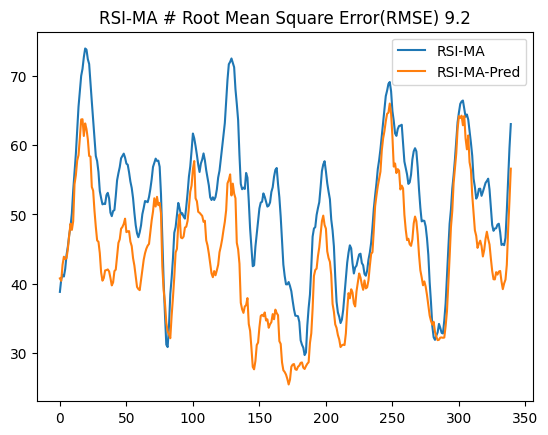

In [132]:
test_df=pd.DataFrame()
listColPair=[]
for i in range(0,len(my_features)): 
  dfActual=pd.DataFrame(data={my_features[i]:test_values[:,i]})  
  dfPred=pd.DataFrame(data={f'{my_features[i]}-Pred':y_test_pred[:,i]})
  listColPair.append([my_features[i],f'{my_features[i]}-Pred'])
  test_df=pd.concat([test_df,dfActual,dfPred],axis=1)
print(test_df.info())

#fig, axs = plt.subplots(nrows=len(listColPair), ncols=1, figsize=(14, 5*len(listColPair)))
for colPair in listColPair:
  # rmse = np.sqrt(mean_squared_error(test_df[colPair[0]], test_df[colPair[1]]))
  # title=f'{colPair[0]} # Root Mean Square Error(RMSE) {round(rmse,2)}'
  mae_x = mean_absolute_error(test_df[colPair[0]], test_df[colPair[1]])
  title=f'{colPair[0]} # {my_model_loss}) {round(mae_x,2)}'  
  test_df[colPair].plot(title=title)
  plt.legend()
  plt.show()

# Predict One Value

In [74]:
print(f"We will use the last {n_input} data to predict the new one")
last_train_batch=train[-n_input:]
print(last_train_batch.shape,last_train_batch)

print("We need reshape first")
last_train_batch =last_train_batch .reshape((1,n_input,n_features))
print(last_train_batch.shape,last_train_batch)

print("Predict")
last_predict=model.predict(last_train_batch)
print(last_predict)

last_predict = scaler.inverse_transform(last_predict)
print(last_predict.shape,last_predict)


We will use the last 60 data to predict the new one
(60, 8) [[0.39077227 0.37290137 0.38332009 0.38332009 0.73236426 0.76341324
  0.39903004 0.45659824]
 [0.37735634 0.36583795 0.37936811 0.37936811 0.71686618 0.75756279
  0.36710225 0.42463343]
 [0.37826847 0.36021298 0.37586718 0.37586718 0.70628474 0.75057078
  0.36993129 0.39398827]
 [0.39698617 0.35948302 0.37472884 0.37472884 0.70831552 0.74472032
  0.42758992 0.38651026]
 [0.38592657 0.35660612 0.37249511 0.37249511 0.70510902 0.73915525
  0.39795231 0.37082111]
 [0.40289602 0.35772253 0.37230181 0.37230181 0.7116289  0.73530251
  0.44914455 0.38181818]
 [0.39900046 0.35785135 0.3717219  0.3717219  0.71515605 0.73259132
  0.43782837 0.39721408]
 [0.42592733 0.36347632 0.37408449 0.37408449 0.73150919 0.73287671
  0.51488616 0.428739  ]
 [0.3979363  0.36233844 0.37320389 0.37320389 0.73011971 0.73287671
  0.43365216 0.43005865]
 [0.40025464 0.36188759 0.37266694 0.37266694 0.73054724 0.73301941
  0.44038798 0.43929619]
 [0.371370

In [ ]:
# model = build_hp_model(best_hps)  # for train entire data for save as final model to run production

#history=model.fit_generator(generator, steps_per_epoch=1, epochs=n_epochs, verbose=0)



# save fro train entire data and for making predition in live produciton
print("Save model and scaler")

file_model='Model_ExplainMultiVarToOne.h5'
file_scaler='Scaler_ExplainMultiVarToOne.gz'
file_scaler_pred='ScalerPred_ExplainMultiVarToOne.gz'

model.save(file_model)
joblib.dump(scaler,file_scaler)
joblib.dump(scaler_pred,file_scaler_pred)


# # Fit with the entire dataset.
# x_all = np.concatenate((x_train, x_val))
# y_all = np.concatenate((y_train, y_val))
# model.fit(x=x_all, y=y_all, epochs=1)